# **Setup**

In [1]:
import requests # use to retrieve data from API
import math
import pandas as pd
import datetime as datetime
import tensorflow as tf
#import os

In [ ]:
# Global var for debugging
show_debug = True



# # Global vars for Weird Gloop API
# game_base = "rs" # API can have two options: rs (Runescape 3) or osrs (Old School Runescape)
# data_filter = "all" # API has three options: all (all price data), last90d (last 90 days), and sample

# # Determine which item category we are interested in.
# # See the following link for all item categories (https://runescape.wiki/w/Application_programming_interface#category).
# item_category = 13 

In [ ]:
# Refer to the following tutorial for the base of the neural net: 
# https://www.tensorflow.org/tutorials/structured_data/time_series#advanced_autoregressive_model

# Import data

In [15]:
data = pd.read_csv("C:/Users/yangs/Documents/Coding/rs3-ml/src/ge-prices-2024-07-28.csv")
display(data)

,index,id,price,volume,timestamp,date,weekday,name,diff_1_day,diff_7_day,diff_14_day,diff_30_day,ma_7_day,ma_14_day,ma_30_day,diff_ma_7_day,diff_ma_14_day,diff_ma_30_day
0,180,52937,1653,NaN,1646092800000,2022-03-01,1,Abyssal flesh,153.0,153.0,153.0,153.0,1521.857143,1510.928571,1505.100000,21.857143,10.928571,5.100000
1,181,52937,1736,NaN,1646179200000,2022-03-02,1,Abyssal flesh,83.0,236.0,236.0,236.0,1555.571429,1527.785714,1512.966667,33.714286,16.857143,7.866667
2,182,52937,1823,NaN,1646265600000,2022-03-03,1,Abyssal flesh,87.0,323.0,323.0,323.0,1601.714286,1550.857143,1523.733333,46.142857,23.071429,10.766667
3,183,52937,1915,NaN,1646352000000,2022-03-04,1,Abyssal flesh,92.0,415.0,415.0,415.0,1661.000000,1580.500000,1537.566667,59.285714,29.642857,13.833333
4,184,52937,2011,NaN,1646438400000,2022-03-05,0,Abyssal flesh,96.0,511.0,511.0,511.0,1734.000000,1617.000000,1554.600000,73.000000,36.500000,17.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550555,723468,43983,483,16747.0,1721748680000,2024-07-23,1,Zygomite fruit,0.0,-31.0,-44.0,-49.0,488.428571,502.142857,512.566667,-4.428571,-3.142857,-1.633333
550556,723469,43983,483,17274.0,1721804620000,2024-07-24,1,Zygomite fruit,0.0,-19.0,-44.0,-63.0,485.714286,499.000000,510.466667,-2.714286,-3.142857,-2.100000
550557,723470,43983,480,15194.0,1721928652000,2024-07-25,1,Zygomite fruit,-3.0,-22.0,-34.0,-66.0,482.571429,496.571429,508.266667,-3.142857,-2.428571,-2.200000
550558,723471,43983,480,11417.0,1721993510000,2024-07-26,1,Zygomite fruit,0.0,-3.0,-34.0,-39.0,482.142857,494.142857,506.966667,-0.428571,-2.428571,-1.300000


# Prepare dataset

In [20]:
# Calculate the target column - predicted price.
data["pred_price"] = data["price"] - data.groupby("id")["price"].diff(-1)
display(data)

,index,id,price,volume,timestamp,date,weekday,name,diff_1_day,diff_7_day,diff_14_day,diff_30_day,ma_7_day,ma_14_day,ma_30_day,diff_ma_7_day,diff_ma_14_day,diff_ma_30_day,pred_price
0,180,52937,1653,NaN,1646092800000,2022-03-01,1,Abyssal flesh,153.0,153.0,153.0,153.0,1521.857143,1510.928571,1505.100000,21.857143,10.928571,5.100000,1736.0
1,181,52937,1736,NaN,1646179200000,2022-03-02,1,Abyssal flesh,83.0,236.0,236.0,236.0,1555.571429,1527.785714,1512.966667,33.714286,16.857143,7.866667,1823.0
2,182,52937,1823,NaN,1646265600000,2022-03-03,1,Abyssal flesh,87.0,323.0,323.0,323.0,1601.714286,1550.857143,1523.733333,46.142857,23.071429,10.766667,1915.0
3,183,52937,1915,NaN,1646352000000,2022-03-04,1,Abyssal flesh,92.0,415.0,415.0,415.0,1661.000000,1580.500000,1537.566667,59.285714,29.642857,13.833333,2011.0
4,184,52937,2011,NaN,1646438400000,2022-03-05,0,Abyssal flesh,96.0,511.0,511.0,511.0,1734.000000,1617.000000,1554.600000,73.000000,36.500000,17.033333,2112.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550555,723468,43983,483,16747.0,1721748680000,2024-07-23,1,Zygomite fruit,0.0,-31.0,-44.0,-49.0,488.428571,502.142857,512.566667,-4.428571,-3.142857,-1.633333,483.0
550556,723469,43983,483,17274.0,1721804620000,2024-07-24,1,Zygomite fruit,0.0,-19.0,-44.0,-63.0,485.714286,499.000000,510.466667,-2.714286,-3.142857,-2.100000,480.0
550557,723470,43983,480,15194.0,1721928652000,2024-07-25,1,Zygomite fruit,-3.0,-22.0,-34.0,-66.0,482.571429,496.571429,508.266667,-3.142857,-2.428571,-2.200000,480.0
550558,723471,43983,480,11417.0,1721993510000,2024-07-26,1,Zygomite fruit,0.0,-3.0,-34.0,-39.0,482.142857,494.142857,506.966667,-0.428571,-2.428571,-1.300000,480.0


In [23]:
# Split this set into historical data (where there is a predicted value i.e the price from the day after) 
# and recent (where there is no future price).
historical_data = data.loc[data['pred_price'].notna()]
recent_data = data.loc[data['pred_price'].isna()]

In [26]:
display(recent_data.head(5))

,index,id,price,volume,timestamp,date,weekday,name,diff_1_day,diff_7_day,diff_14_day,diff_30_day,ma_7_day,ma_14_day,ma_30_day,diff_ma_7_day,diff_ma_14_day,diff_ma_30_day,pred_price
858,1041,52937,965,112204.0,1722066488000,2024-07-27,0,Abyssal flesh,0.0,-16.0,20.0,3.0,977.142857,970.142857,951.500000,-2.285714,1.428571,0.100000,NaN
3176,4004,39067,10959,53755.0,1722066488000,2024-07-27,0,Adrenaline crystal,356.0,904.0,1428.0,2977.0,10417.857143,10073.714286,9370.933333,129.142857,102.000000,99.233333,NaN
3731,5986,48241,16279,1382.0,1719938689000,2024-07-02,1,Arbuck potion (unf),0.0,440.0,440.0,440.0,16279.000000,16059.000000,15941.666667,62.857143,31.428571,14.666667,NaN
8833,11904,592,1466,868441.0,1722066488000,2024-07-27,0,Ashes,-23.0,81.0,211.0,389.0,1475.571429,1388.428571,1297.166667,11.571429,15.071429,12.966667,NaN
14540,17796,103,1928,56478.0,1722066488000,2024-07-27,0,Avantoe potion (unf),0.0,66.0,66.0,139.0,1890.285714,1876.142857,1839.733333,9.428571,4.714286,4.633333,NaN


# Create neural net

## Split data

In [31]:
from sklearn.model_selection import train_test_split

In [ ]:
# Contain this information into the request data component.
data.columns

In [112]:
# split into features and target
features = ['price', 'diff_1_day', 'diff_7_day', 'diff_14_day', 'diff_30_day',
       'ma_7_day', 'ma_14_day', 'ma_30_day', 'diff_ma_7_day', 'diff_ma_14_day',
       'diff_ma_30_day']

target = "pred_price"

In [73]:
x = historical_data[features]
y = historical_data[target]

In [74]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state = 123)

In [75]:
display(x_train)

,price,diff_1_day,diff_7_day,diff_14_day,diff_30_day,ma_7_day,ma_14_day,ma_30_day,diff_ma_7_day,diff_ma_14_day,diff_ma_30_day
373854,1306,20.0,75.0,63.0,151.0,1262.857143,1243.928571,1218.600000,10.714286,4.500000,5.033333
18128,15977,0.0,352.0,334.0,-147.0,15876.428571,15750.714286,15853.600000,50.285714,23.857143,-4.900000
97911,2128,-37.0,-172.0,-587.0,-63.0,2268.857143,2406.857143,2431.200000,-24.571429,-41.928571,-2.100000
392383,3239,-56.0,-78.0,-61.0,-491.0,3260.142857,3276.428571,3297.633333,-11.142857,-4.357143,-16.366667
394283,279,11.0,74.0,47.0,71.0,247.857143,234.142857,228.733333,10.571429,3.357143,2.366667
...,...,...,...,...,...,...,...,...,...,...,...
194327,9864,-65.0,-1.0,-184.0,-305.0,10035.571429,9984.571429,10087.733333,-0.142857,-13.142857,-10.166667
192525,2525,0.0,2.0,2.0,200.0,2524.714286,2523.857143,2473.866667,0.285714,0.142857,6.666667
17737,19378,398.0,398.0,676.0,413.0,19036.857143,18988.571429,18879.566667,56.857143,48.285714,13.766667
28040,8312,82.0,-468.0,-273.0,-1545.0,8506.285714,8660.714286,8926.266667,-66.857143,-19.500000,-51.500000


In [76]:
display(y_train)

373854     1305.0
18128     15977.0
97911      2154.0
392383     3236.0
394283      285.0
           ...   
194327     9757.0
192525     2525.0
17737     19378.0
28040      8176.0
277936     1842.0
Name: pred_price, Length: 385284, dtype: float64

## Construct normalization

In [77]:
# Create tensor from training features and make a normalizer.
x_train_tensor = tf.convert_to_tensor(x_train)
norm = tf.keras.layers.Normalization(axis=-1)
norm.adapt(x_train_tensor)


In [78]:
norm_mean = norm.mean.numpy()[0]
norm_var = norm.variance.numpy()[0]
for c in range(0, len(x_train.columns), 1):
    print(f"{x_train.columns[c]} normalization: mean {norm_mean[c]}; variance {norm_var[c]}")

price normalization: mean 4407.958984375; variance 125274296.0
diff_1_day normalization: mean 1.226290225982666; variance 94595.6953125
diff_7_day normalization: mean 5.411192893981934; variance 933450.3125
diff_14_day normalization: mean 8.356206893920898; variance 2159497.75
diff_30_day normalization: mean 16.480287551879883; variance 5102007.5
ma_7_day normalization: mean 4405.25244140625; variance 124942152.0
ma_14_day normalization: mean 4403.0380859375; variance 124693736.0
ma_30_day normalization: mean 4399.36376953125; variance 124221480.0
diff_ma_7_day normalization: mean 0.7730275392532349; variance 19050.005859375
diff_ma_14_day normalization: mean 0.5968719720840454; variance 11017.845703125
diff_ma_30_day normalization: mean 0.549342930316925; variance 5668.89697265625


## Compile model

In [79]:
# Base function to create model - tune as we go.
def get_regression_model():    
    model = tf.keras.Sequential([
        norm,
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

    return model

In [81]:
# Create model.
price_model = get_regression_model()
price_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (385284, 11)           │            23 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23 (96.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23 (96.00 B)

In [82]:
# Fit model to training and testing data.
price_model_history = price_model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    verbose=0, epochs=100)

In [88]:
import matplotlib.pyplot as plt

In [91]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)


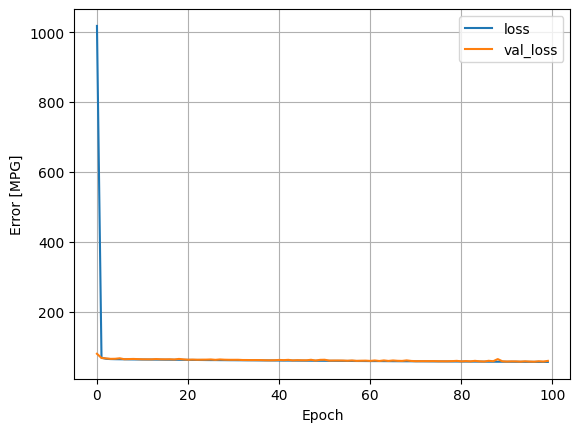

In [92]:
plot_loss(price_model_history)

In [98]:
price_model.evaluate(x_test, y_test, verbose=0)

59.58814239501953

In [100]:
y_test_pred = price_model.predict(x_test)

5161/5161 ━━━━━━━━━━━━━━━━━━━━ 4s 864us/step


[]

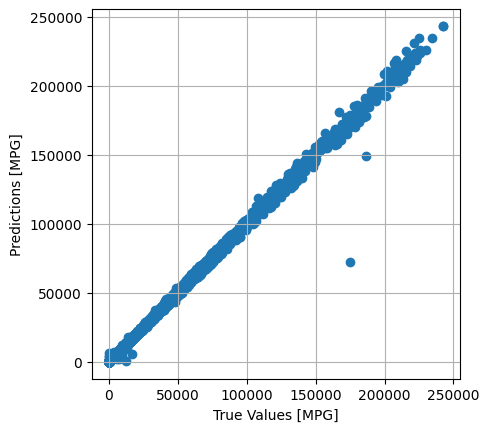

In [102]:
# view comparison between true and predicted values
plt.axes(aspect='equal')
plt.scatter(y_test, y_test_pred)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.grid(True)
plt.plot()


# Predict recent prices

In [115]:
price_features = recent_data[features].copy()
#label = recent_data[target]

In [114]:
price_label = price_model.predict(price_features)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [119]:
price_features["prediction"] = price_label.round(0)
display(price_features)

,price,diff_1_day,diff_7_day,diff_14_day,diff_30_day,ma_7_day,ma_14_day,ma_30_day,diff_ma_7_day,diff_ma_14_day,diff_ma_30_day,prediction
858,965,0.0,-16.0,20.0,3.0,977.142857,970.142857,951.500000,-2.285714,1.428571,0.100000,965.0
3176,10959,356.0,904.0,1428.0,2977.0,10417.857143,10073.714286,9370.933333,129.142857,102.000000,99.233333,10996.0
3731,16279,0.0,440.0,440.0,440.0,16279.000000,16059.000000,15941.666667,62.857143,31.428571,14.666667,16351.0
8833,1466,-23.0,81.0,211.0,389.0,1475.571429,1388.428571,1297.166667,11.571429,15.071429,12.966667,1468.0
14540,1928,0.0,66.0,66.0,139.0,1890.285714,1876.142857,1839.733333,9.428571,4.714286,4.633333,1931.0
...,...,...,...,...,...,...,...,...,...,...,...,...
542589,697,-3.0,-43.0,-56.0,-26.0,716.714286,724.428571,726.866667,-6.142857,-4.000000,-0.866667,695.0
544364,7528,0.0,-281.0,-477.0,-398.0,7568.142857,7716.571429,7870.133333,-40.142857,-34.071429,-13.266667,7535.0
546490,147419,0.0,4328.0,416.0,-12553.0,146339.142857,145072.928571,150539.566667,618.285714,29.714286,-418.433333,147986.0
548499,326,-4.0,4.0,-7.0,22.0,328.285714,327.500000,322.700000,0.571429,-0.500000,0.733333,325.0


In [121]:
price_predicted = price_features.merge(data[["id","date", "name"]], left_index = True, right_index = True)

# Export data

In [123]:
import datetime

# Create file based on date.
today = datetime.date.today().strftime('%Y-%m-%d')
print(f"Current date: {today}")

filename = f"predicted-prices-{today}.csv"
print(f"Final filename: {filename}")

Current date: 2024-07-31
Final filename: predicted-prices-2024-07-31.csv


In [124]:
price_predicted.to_csv(filename, index=False)  